# ML Classification Demo: Choose Your Method

This notebook lets you run text classification on the 20 Newsgroups dataset using your choice of:
- **Naive Bayes**: Fast, simple probabilistic classifier
- **Random Forest**: Ensemble method with multiple decision trees

The analysis trains on 900 posts and evaluates on 100 test posts, generating:
- Accuracy metrics and confusion matrices
- Visualizations (distribution, accuracy by category, error patterns)
- Detailed CSV results and markdown reports

## Quick Start
1. **Choose your method** in Step 2 (set `CLASSIFICATION_METHOD`)
2. Set your API keys in Step 3
3. Run all cells to see the classification in action

In [1]:
# ============================================================================
# STEP 1: Install Dependencies
# ============================================================================

!pip install daytona==0.25.5
!pip install claude-code-sdk==0.0.20
!pip install asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.8/287.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.1 MB/s eta 0:00:00


In [2]:
# ============================================================================
# STEP 2: CONFIGURATION - CHOOSE YOUR CLASSIFICATION METHOD
# ============================================================================

# 🔧 EDIT THIS: Choose "naive_bayes" or "random_forest"
CLASSIFICATION_METHOD = "naive_bayes"  # Options: "naive_bayes" or "random_forest"

print(f"✓ Selected classification method: {CLASSIFICATION_METHOD.upper()}")
print("\n💡 To change method, edit CLASSIFICATION_METHOD above and re-run this cell")

✓ Selected classification method: NAIVE_BAYES

💡 To change method, edit CLASSIFICATION_METHOD above and re-run this cell


In [ ]:
# ============================================================================
# STEP 3: Imports and API Keys
# ============================================================================
import os
import asyncio
import json
import pandas as pd
from datetime import datetime
from typing import List, Dict, Any
from sklearn.datasets import fetch_20newsgroups

# Set your API keys here
DAYTONA_API_KEY = os.getenv("DAYTONA_API_KEY", "your-daytona-api-key-here")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY", "your-anthropic-api-key-here")
DAYTONA_API_URL = os.getenv("DAYTONA_API_URL", "https://app.daytona.io/api")

if DAYTONA_API_KEY == "your-daytona-api-key-here":
    raise ValueError("❌ Please set DAYTONA_API_KEY")
if ANTHROPIC_API_KEY == "your-anthropic-api-key-here":
    raise ValueError("❌ Please set ANTHROPIC_API_KEY")

print("✓ Environment configured")

✓ Environment configured


In [4]:
# ============================================================================
# STEP 4: Configure Daytona SDK
# ============================================================================
from daytona import AsyncDaytona, DaytonaConfig, CreateSandboxFromSnapshotParams

config = DaytonaConfig(api_key=DAYTONA_API_KEY, api_url=DAYTONA_API_URL)
print("✓ Daytona SDK configured")

✓ Daytona SDK configured


In [5]:
# ============================================================================
# STEP 5: Dataset Preparation
# ============================================================================
def prepare_newsgroups_dataset(total_samples: int = 1000, random_state: int = 42):
    """Download and prepare 20newsgroups dataset"""
    print(f"📊 Downloading 20newsgroups dataset...")
    newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

    print(f"   ✓ Downloaded {len(newsgroups.data)} total posts")
    print(f"   ✓ Categories: {len(newsgroups.target_names)}")

    df = pd.DataFrame({
        'text': newsgroups.data,
        'target': newsgroups.target,
        'category_name': [newsgroups.target_names[t] for t in newsgroups.target]
    })

    if len(df) > total_samples:
        df_sample = df.sample(n=total_samples, random_state=random_state)
        print(f"   ✓ Sampled {total_samples} posts randomly")
    else:
        df_sample = df
        print(f"   ✓ Using all {len(df)} posts")

    csv_path = "20newsgroups_1000.csv"
    df_sample.to_csv(csv_path, index=False)
    print(f"   ✓ Saved to: {csv_path}")

    return csv_path, sorted(newsgroups.target_names)

print("✓ Dataset preparation function defined")

✓ Dataset preparation function defined


In [6]:
# ============================================================================
# STEP 6: Sandbox Manager
# ============================================================================
class SandboxManager:
    def __init__(self, session_id: str):
        self.session_id = session_id
        self.daytona_client = AsyncDaytona(config)
        self.sandbox = None
        self.project_dir = "/workspace/coding_agent"

    async def __aenter__(self):
        await self.daytona_client.__aenter__()
        print(f"🚀 Creating sandbox ({self.session_id})...")

        snapshot_params = CreateSandboxFromSnapshotParams(
            snapshot="python-ds-claude",
            auto_stop_interval=10,
            auto_delete_interval=0,
        )

        self.sandbox = await self.daytona_client.create(snapshot_params)
        print(f"✓ Sandbox created: {self.sandbox.id}")
        print(f"  Status: {self.sandbox.state}")
        return self

    async def __aexit__(self, exc_type, exc, tb):
        await self.daytona_client.__aexit__(exc_type, exc, tb)
        print(f"🧹 Sandbox will auto-delete in 10 minutes")

    async def upload_file(self, local_path: str, target_name: str):
        """Upload local file to sandbox"""
        print(f"\n📤 Uploading {target_name} to sandbox...")

        try:
            with open(local_path, 'rb') as f:
                file_content = f.read()

            target_path = f"{self.project_dir}/{target_name}"
            await self.sandbox.fs.upload_file(file_content, target_path)

            # Verify upload
            verify_result = await self.sandbox.process.exec(
                f"ls -lh {target_name} && wc -l {target_name}",
                cwd=self.project_dir
            )

            print(f"   ✓ Upload successful")
            if verify_result.result:
                print(f"   ✓ Verification: {verify_result.result.strip()}")

            return True
        except Exception as e:
            print(f"   ❌ Upload failed: {e}")
            return False

    def _build_generation_script(self, prompt: str) -> str:
        """Build Python script with analysis prompt"""
        escaped_prompt = prompt.replace('"""', '\\"\\"\\"')

        script = f'''#!/usr/bin/env python3
import asyncio
import os
import json
from pathlib import Path
from claude_code_sdk import query, ClaudeCodeOptions

async def generate_analysis():
    prompt = """{escaped_prompt}"""

    print("🤖 Starting Claude Code analysis...")

    options = ClaudeCodeOptions(
        max_turns=60,
        allowed_tools=["Read", "Write", "Edit", "Bash", "Glob", "Grep"]
    )

    messages = []
    log_data = []

    async for message in query(prompt=prompt, options=options):
        messages.append(message)

        # Print type indicator
        if hasattr(message, 'type'):
            print(f"[{{message.type}}]", end=" ")

        # Collect detailed log data
        try:
            log_entry = {{
                'index': len(log_data),
                'type': type(message).__name__,
                'content': str(message)[:1000]  # First 1000 chars
            }}
            if hasattr(message, 'role'):
                log_entry['role'] = message.role
            if hasattr(message, 'content'):
                log_entry['message_content'] = str(message.content)[:500]

            log_data.append(log_entry)
        except Exception as e:
            log_data.append({{
                'index': len(log_data),
                'type': 'serialization_error',
                'error': str(e)
            }})

    print(f"\\n✓ Completed {{len(messages)}} messages")

    # Save structured log as JSON
    print(f"Saving {{len(log_data)}} messages to claude_code_execution.log")
    try:
        with open('claude_code_execution.log', 'w') as f:
            json.dump(log_data, f, indent=2)
        print("✓ Generation log saved")
        print(f"Log file size: {{os.path.getsize('claude_code_execution.log')}} bytes")
    except Exception as log_error:
        print(f"❌ Failed to save log: {{log_error}}")

    # List generated files
    files = [f.name for f in Path('.').iterdir() if f.is_file() and not f.name.startswith('.')]
    print(f"\\n📄 Generated files: {{', '.join(files)}}")

if __name__ == "__main__":
    asyncio.run(generate_analysis())
'''
        return script

    async def generate_code(self, prompt: str, timeout: int = 1500):
        """Generate code in sandbox"""
        print(f"\n🤖 Starting code generation...")

        try:
            # Upload generation script
            script = self._build_generation_script(prompt)
            script_path = f"{self.project_dir}/generate_analysis.py"
            await self.sandbox.fs.upload_file(script.encode("utf-8"), script_path)

            # Execute
            print(f"   ⏳ Running analysis (timeout: {timeout}s)...")
            result = await asyncio.wait_for(
                self.sandbox.process.exec(
                    f"python generate_analysis.py",
                    cwd=self.project_dir,
                    env={"ANTHROPIC_API_KEY": ANTHROPIC_API_KEY},
                    timeout=timeout,
                ),
                timeout=timeout,
            )

            if result.exit_code != 0:
                return {"success": False, "error": result.result}

            # Download generated files
            files = await self._download_files()

            print(f"   ✓ Analysis completed successfully")

            return {
                "success": True,
                "sandbox_id": self.sandbox.id,
                "files": files,
                "execution_output": result.result,
            }
        except Exception as e:
            print(f"   ❌ Error: {str(e)}")
            return {"success": False, "error": str(e)}

    async def _download_files(self):
        """Download all generated files"""
        print(f"\n📥 Downloading generated files...")

        files_list = await self.sandbox.fs.list_files(self.project_dir)
        relevant_files = [
            f for f in files_list
            if not f.name.startswith('.')
            and f.name not in ['generate_analysis.py', '20newsgroups_1000.csv']
        ]

        print(f"   Found {len(relevant_files)} files to download")

        downloaded = []
        for file_info in relevant_files:
            try:
                full_path = f"{self.project_dir}/{file_info.name}"
                content = await self.sandbox.fs.download_file(full_path)
                downloaded.append({
                    "name": file_info.name,
                    "content": content,
                    "size": len(content)
                })
                print(f"   ✓ {file_info.name} ({len(content)} bytes)")
            except Exception as e:
                print(f"   ⚠️ Failed to download {file_info.name}: {e}")

        return downloaded

print("✓ SandboxManager defined")

✓ SandboxManager defined


In [7]:
# ============================================================================
# STEP 7: Classification Prompts (EDIT THESE!)
# ============================================================================

def get_shared_analysis_instructions():
    """Shared analysis and reporting instructions for both methods"""
    return '''
4. EVALUATE AND VISUALIZE RESULTS
   - Calculate overall accuracy on the 100 test posts
   - Calculate number of correct and incorrect predictions
   - Calculate accuracy for each category in the test sample
   - Generate visualizations:
     * Bar chart: distribution of actual categories in test sample (save as category_distribution.png)
     * Bar chart: per-category accuracy comparison (save as accuracy_by_category.png)
     * Confusion Matrix heatmap for the 100 test posts (save as confusion_matrix.png)
     * Bar chart: most common misclassification patterns (save as top_errors.png)
   - Save classification results (actual, predicted, correctness) to classification_results.csv

5. WRITE ANALYSIS REPORT
   - Write a markdown report (analysis_report.md) summarizing:
     * Methodology and dataset details
     * Overall accuracy and key findings
     * Category distribution and per-category accuracy
     * Confusion matrix insights
     * Misclassification patterns
     * Limitations and when more sophisticated methods are needed

EXPECTED OUTPUT FILES:
- analysis_report.md
- category_distribution.png
- accuracy_by_category.png
- confusion_matrix.png
- top_errors.png
- classification_results.csv

Import all necessary libraries (pandas, scikit-learn, matplotlib, seaborn). No external API calls.
IMPORTANT: Don't use ps commands.
'''

def build_naive_bayes_prompt(category_list: List[str]) -> str:
    """Naive Bayes classification prompt - EDIT THIS to customize!"""
    categories_str = "\n".join([f"  - {cat}" for cat in category_list])
    shared_instructions = get_shared_analysis_instructions()

    prompt = f'''You are analyzing the 20 Newsgroups dataset using Naive Bayes classification.

DATASET: 20newsgroups_1000.csv
- Columns: text, target, category_name
- 1000 newsgroup posts across 20 categories

CATEGORIES:
{categories_str}

TASK - Naive Bayes Text Classification:

1. LOAD AND EXPLORE DATA
   - Read 20newsgroups_1000.csv
   - Display dataset shape and category distribution
   - Show sample posts from different categories

2. SPLIT DATA
   - Randomly sample 100 posts as test set
   - Use remaining 900 posts as training set
   - Ensure test set includes actual category names

3. NAIVE BAYES CLASSIFICATION
   - Train a Naive Bayes classifier (scikit-learn) on 900 training posts
   - Use TF-IDF vectorization for features
   - Predict categories for 100 test posts

{shared_instructions}
'''
    return prompt

def build_random_forest_prompt(category_list: List[str]) -> str:
    """Random Forest classification prompt - EDIT THIS to customize!"""
    categories_str = "\n".join([f"  - {cat}" for cat in category_list])
    shared_instructions = get_shared_analysis_instructions()

    prompt = f'''You are analyzing the 20 Newsgroups dataset using Random Forest classification.

DATASET: 20newsgroups_1000.csv
- Columns: text, target, category_name
- 1000 newsgroup posts across 20 categories

CATEGORIES:
{categories_str}

TASK - Random Forest Text Classification:

1. LOAD AND EXPLORE DATA
   - Read 20newsgroups_1000.csv
   - Display dataset shape and category distribution
   - Show sample posts from different categories

2. SPLIT DATA
   - Randomly sample 100 posts as test set
   - Use remaining 900 posts as training set
   - Ensure test set includes actual category names

3. RANDOM FOREST CLASSIFICATION
   - Train a Random Forest classifier (scikit-learn) on 900 training posts
   - Use TF-IDF vectorization for features
   - Configure with n_estimators=100 and random_state=42
   - Predict categories for 100 test posts

{shared_instructions}
'''
    return prompt

print("✓ Classification prompts defined")
print("\n💡 You can edit build_naive_bayes_prompt() and build_random_forest_prompt() to customize!")

✓ Classification prompts defined

💡 You can edit build_naive_bayes_prompt() and build_random_forest_prompt() to customize!


In [8]:
# ============================================================================
# STEP 8: Main Execution Flow
# ============================================================================

async def run_classification():
    """Run the selected classification method"""

    # Validate method selection
    if CLASSIFICATION_METHOD not in ["naive_bayes", "random_forest"]:
        raise ValueError(f"Invalid CLASSIFICATION_METHOD: {CLASSIFICATION_METHOD}. Must be 'naive_bayes' or 'random_forest'")

    method_name = "Naive Bayes" if CLASSIFICATION_METHOD == "naive_bayes" else "Random Forest"

    print("\n" + "="*70)
    print(f"{method_name.upper()} TEXT CLASSIFICATION ANALYSIS")
    print("="*70)
    print(f"\nMethod: {method_name}")
    print("Dataset: 20 Newsgroups (900 train / 100 test)")

    # Step 1: Prepare dataset
    print("\n" + "="*70)
    print("PHASE 1: DATASET PREPARATION")
    print("="*70)
    csv_path, category_list = prepare_newsgroups_dataset(total_samples=1000, random_state=42)

    print(f"\n✓ Dataset ready:")
    print(f"   - File: {csv_path}")
    print(f"   - Categories: {len(category_list)}")
    print(f"   - Sample categories: {', '.join(category_list[:5])}...")

    # Step 2: Create sandbox and upload data
    print("\n" + "="*70)
    print("PHASE 2: DAYTONA SANDBOX & DATA UPLOAD")
    print("="*70)

    async with SandboxManager(session_id=f"{CLASSIFICATION_METHOD}-classification") as manager:

        # Upload CSV
        upload_success = await manager.upload_file(csv_path, "20newsgroups_1000.csv")

        if not upload_success:
            print("\n❌ Failed to upload dataset. Aborting.")
            return

        # Step 3: Run classification analysis
        print("\n" + "="*70)
        print(f"PHASE 3: {method_name.upper()} CLASSIFICATION ANALYSIS")
        print("="*70)
        print("\nThis will:")
        print("  1. Sample 100 posts randomly from the 1000")
        print(f"  2. Train a {method_name} model on 900 posts")
        print("  3. Predict categories for the 100 test posts")
        print("  4. Compare predictions vs actual labels")
        print("  5. Generate visualizations and analysis report")
        print("\nEstimated time: A few minutes")

        # Build prompt based on selected method
        if CLASSIFICATION_METHOD == "naive_bayes":
            prompt = build_naive_bayes_prompt(category_list)
        else:
            prompt = build_random_forest_prompt(category_list)

        # Execute analysis
        result = await manager.generate_code(prompt=prompt, timeout=1500)

        # Step 4: Display results
        print("\n" + "="*70)
        print("PHASE 4: RESULTS")
        print("="*70)

        if result["success"]:
            print("\n✅ ANALYSIS COMPLETED SUCCESSFULLY")
            print(f"\nSandbox ID: {result['sandbox_id']}")
            print(f"Files generated: {len(result['files'])}")

            # Create output directory with timestamp
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            output_dir = f"./{CLASSIFICATION_METHOD}_results_{timestamp}"
            os.makedirs(output_dir, exist_ok=True)
            print(f"\n💾 Saving results to: {output_dir}")

            # Find and display markdown report
            markdown_report = None
            visualizations = []
            csv_results = None

            # Save all files locally
            for file_info in result["files"]:
                file_name = file_info["name"]
                file_path = os.path.join(output_dir, file_name)

                # Save content - handle binary and text files
                try:
                    if isinstance(file_info["content"], bytes):
                        with open(file_path, 'wb') as f:
                            f.write(file_info["content"])
                        print(f"   ✓ Saved: {file_name} ({file_info['size']} bytes)")
                    else:
                        with open(file_path, 'w', encoding='utf-8') as f:
                            f.write(file_info["content"])
                        print(f"   ✓ Saved: {file_name}")
                except Exception as e:
                    print(f"   ❌ Failed to save {file_name}: {e}")

                # Categorize files
                if file_info["name"] == "analysis_report.md":
                    try:
                        markdown_report = file_info["content"].decode("utf-8") if isinstance(file_info["content"], bytes) else file_info["content"]
                    except Exception as e:
                        print(f"   ⚠️  Could not decode markdown report: {e}")
                        markdown_report = "Error decoding markdown report."
                elif file_info["name"].endswith(".png"):
                    visualizations.append(file_info["name"])
                elif file_info["name"] == "classification_results.csv":
                    csv_results = file_info["name"]

            # Display executive summary
            if markdown_report:
                print("\n" + "="*70)
                print("📄 ANALYSIS REPORT")
                print("="*70)
                print(markdown_report)
            else:
                print("\n⚠️  Warning: analysis_report.md not found")

            # List visualizations
            if visualizations:
                print("\n" + "="*70)
                print("📊 VISUALIZATIONS GENERATED")
                print("="*70)
                for viz in visualizations:
                    print(f"   ✓ {viz}")

            # Note about detailed results
            if csv_results:
                print("\n" + "="*70)
                print("📈 DETAILED RESULTS")
                print("="*70)
                print(f"   ✓ {csv_results} - Contains all 100 predictions with actual vs predicted labels")

            print("\n" + "="*70)
            print(f"🎉 {method_name.upper()} TEXT CLASSIFICATION COMPLETE")
            print("="*70)
            print(f"\n📁 All results saved to: {output_dir}")
            print("\nKey Outputs:")
            print("  • Analysis report with methodology and insights")
            print("  • Accuracy metrics and confusion matrix")
            print("  • Visualizations showing performance by category")
            print("  • Detailed CSV with all predictions")

            # Display images inline if in notebook
            try:
                from IPython.display import Image, display
                if visualizations:
                    print("\n" + "="*70)
                    print("📊 VISUALIZATIONS (INLINE)")
                    print("="*70)
                    for viz in visualizations:
                        viz_path = os.path.join(output_dir, viz)
                        if os.path.exists(viz_path):
                            print(f"\n{viz}:")
                            display(Image(filename=viz_path))
            except ImportError:
                pass  # Not in notebook, skip inline display

        else:
            print(f"\n❌ ANALYSIS FAILED")
            print(f"Error: {result.get('error', 'Unknown error')}")
            print("\n💡 Troubleshooting:")
            print("  • Check ANTHROPIC_API_KEY is valid")
            print("  • Verify Claude API has available quota")
            print("  • Check sandbox logs for detailed errors")
            print("  • You may re-run this cell to retry")

print("✓ Main execution flow defined")

✓ Main execution flow defined



NAIVE BAYES TEXT CLASSIFICATION ANALYSIS

Method: Naive Bayes
Dataset: 20 Newsgroups (900 train / 100 test)

PHASE 1: DATASET PREPARATION
📊 Downloading 20newsgroups dataset...
   ✓ Downloaded 11314 total posts
   ✓ Categories: 20
   ✓ Sampled 1000 posts randomly
   ✓ Saved to: 20newsgroups_1000.csv

✓ Dataset ready:
   - File: 20newsgroups_1000.csv
   - Categories: 20
   - Sample categories: alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware...

PHASE 2: DAYTONA SANDBOX & DATA UPLOAD
🚀 Creating sandbox (naive_bayes-classification)...
✓ Sandbox created: 48e4ae57-f7d5-4d43-884c-6b7c9ece6b4a
  Status: SandboxState.STARTED

📤 Uploading 20newsgroups_1000.csv to sandbox...
   ✓ Upload successful
   ✓ Verification: -rw-r--r-- 1 dev dev 1.1M Oct 21 10:02 20newsgroups_1000.csv
24668 20newsgroups_1000.csv

PHASE 3: NAIVE BAYES CLASSIFICATION ANALYSIS

This will:
  1. Sample 100 posts randomly from the 1000
  2. Train a Naive Bayes model on 900 p

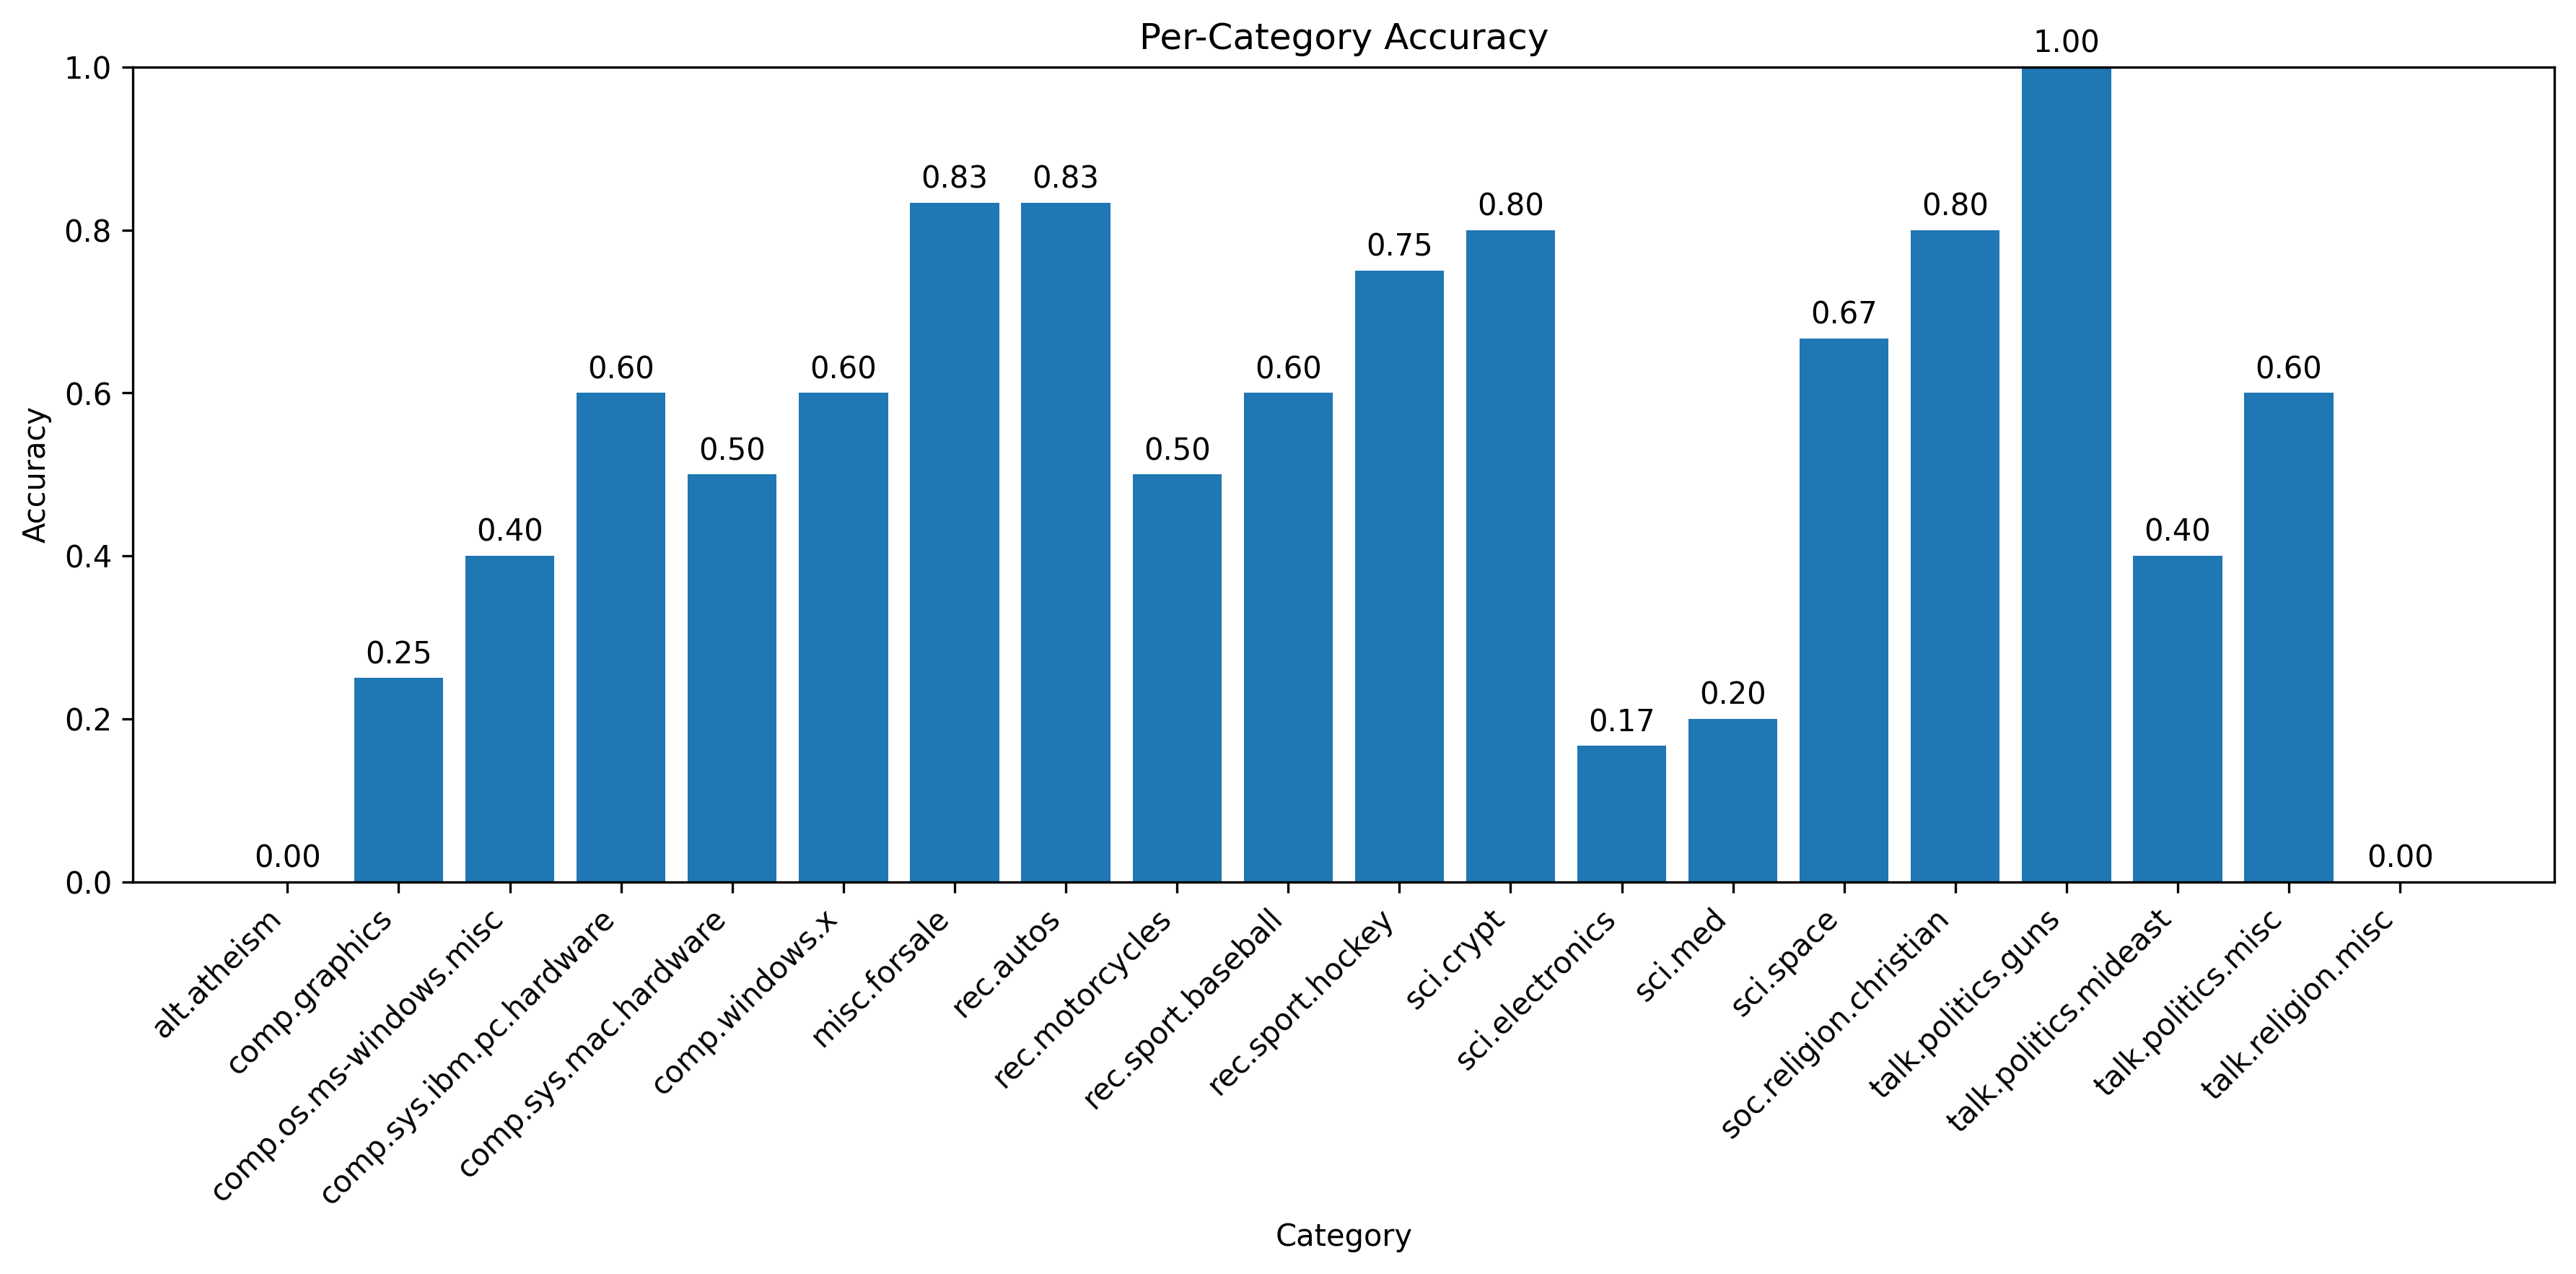


category_distribution.png:


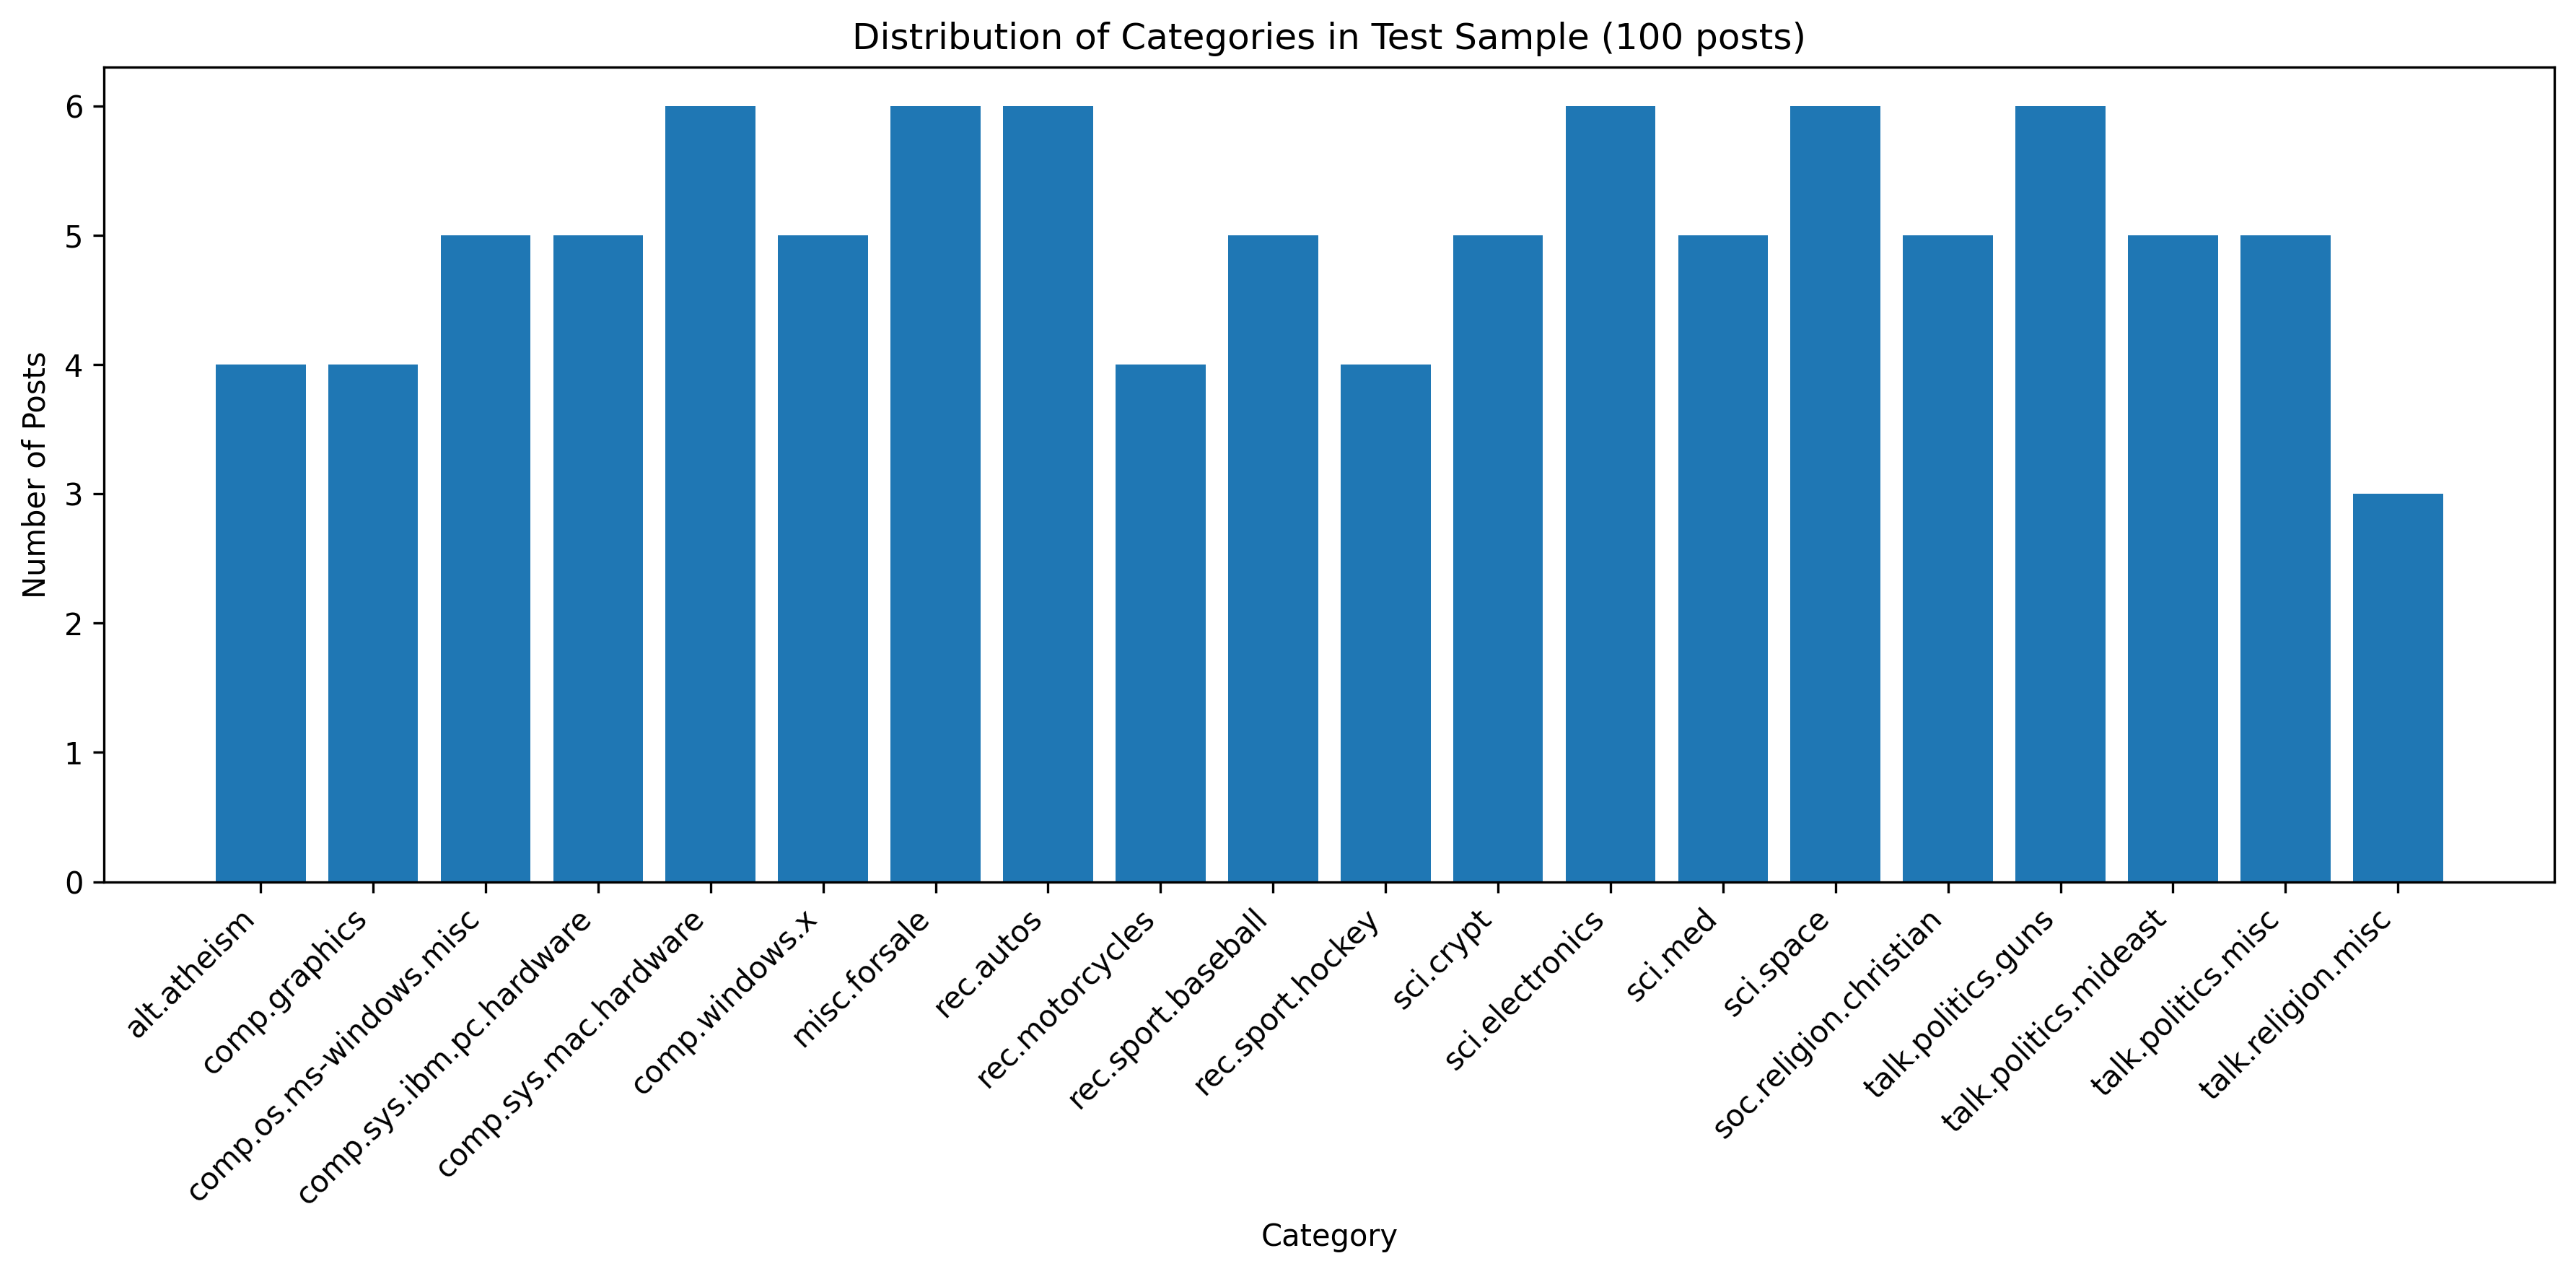


confusion_matrix.png:


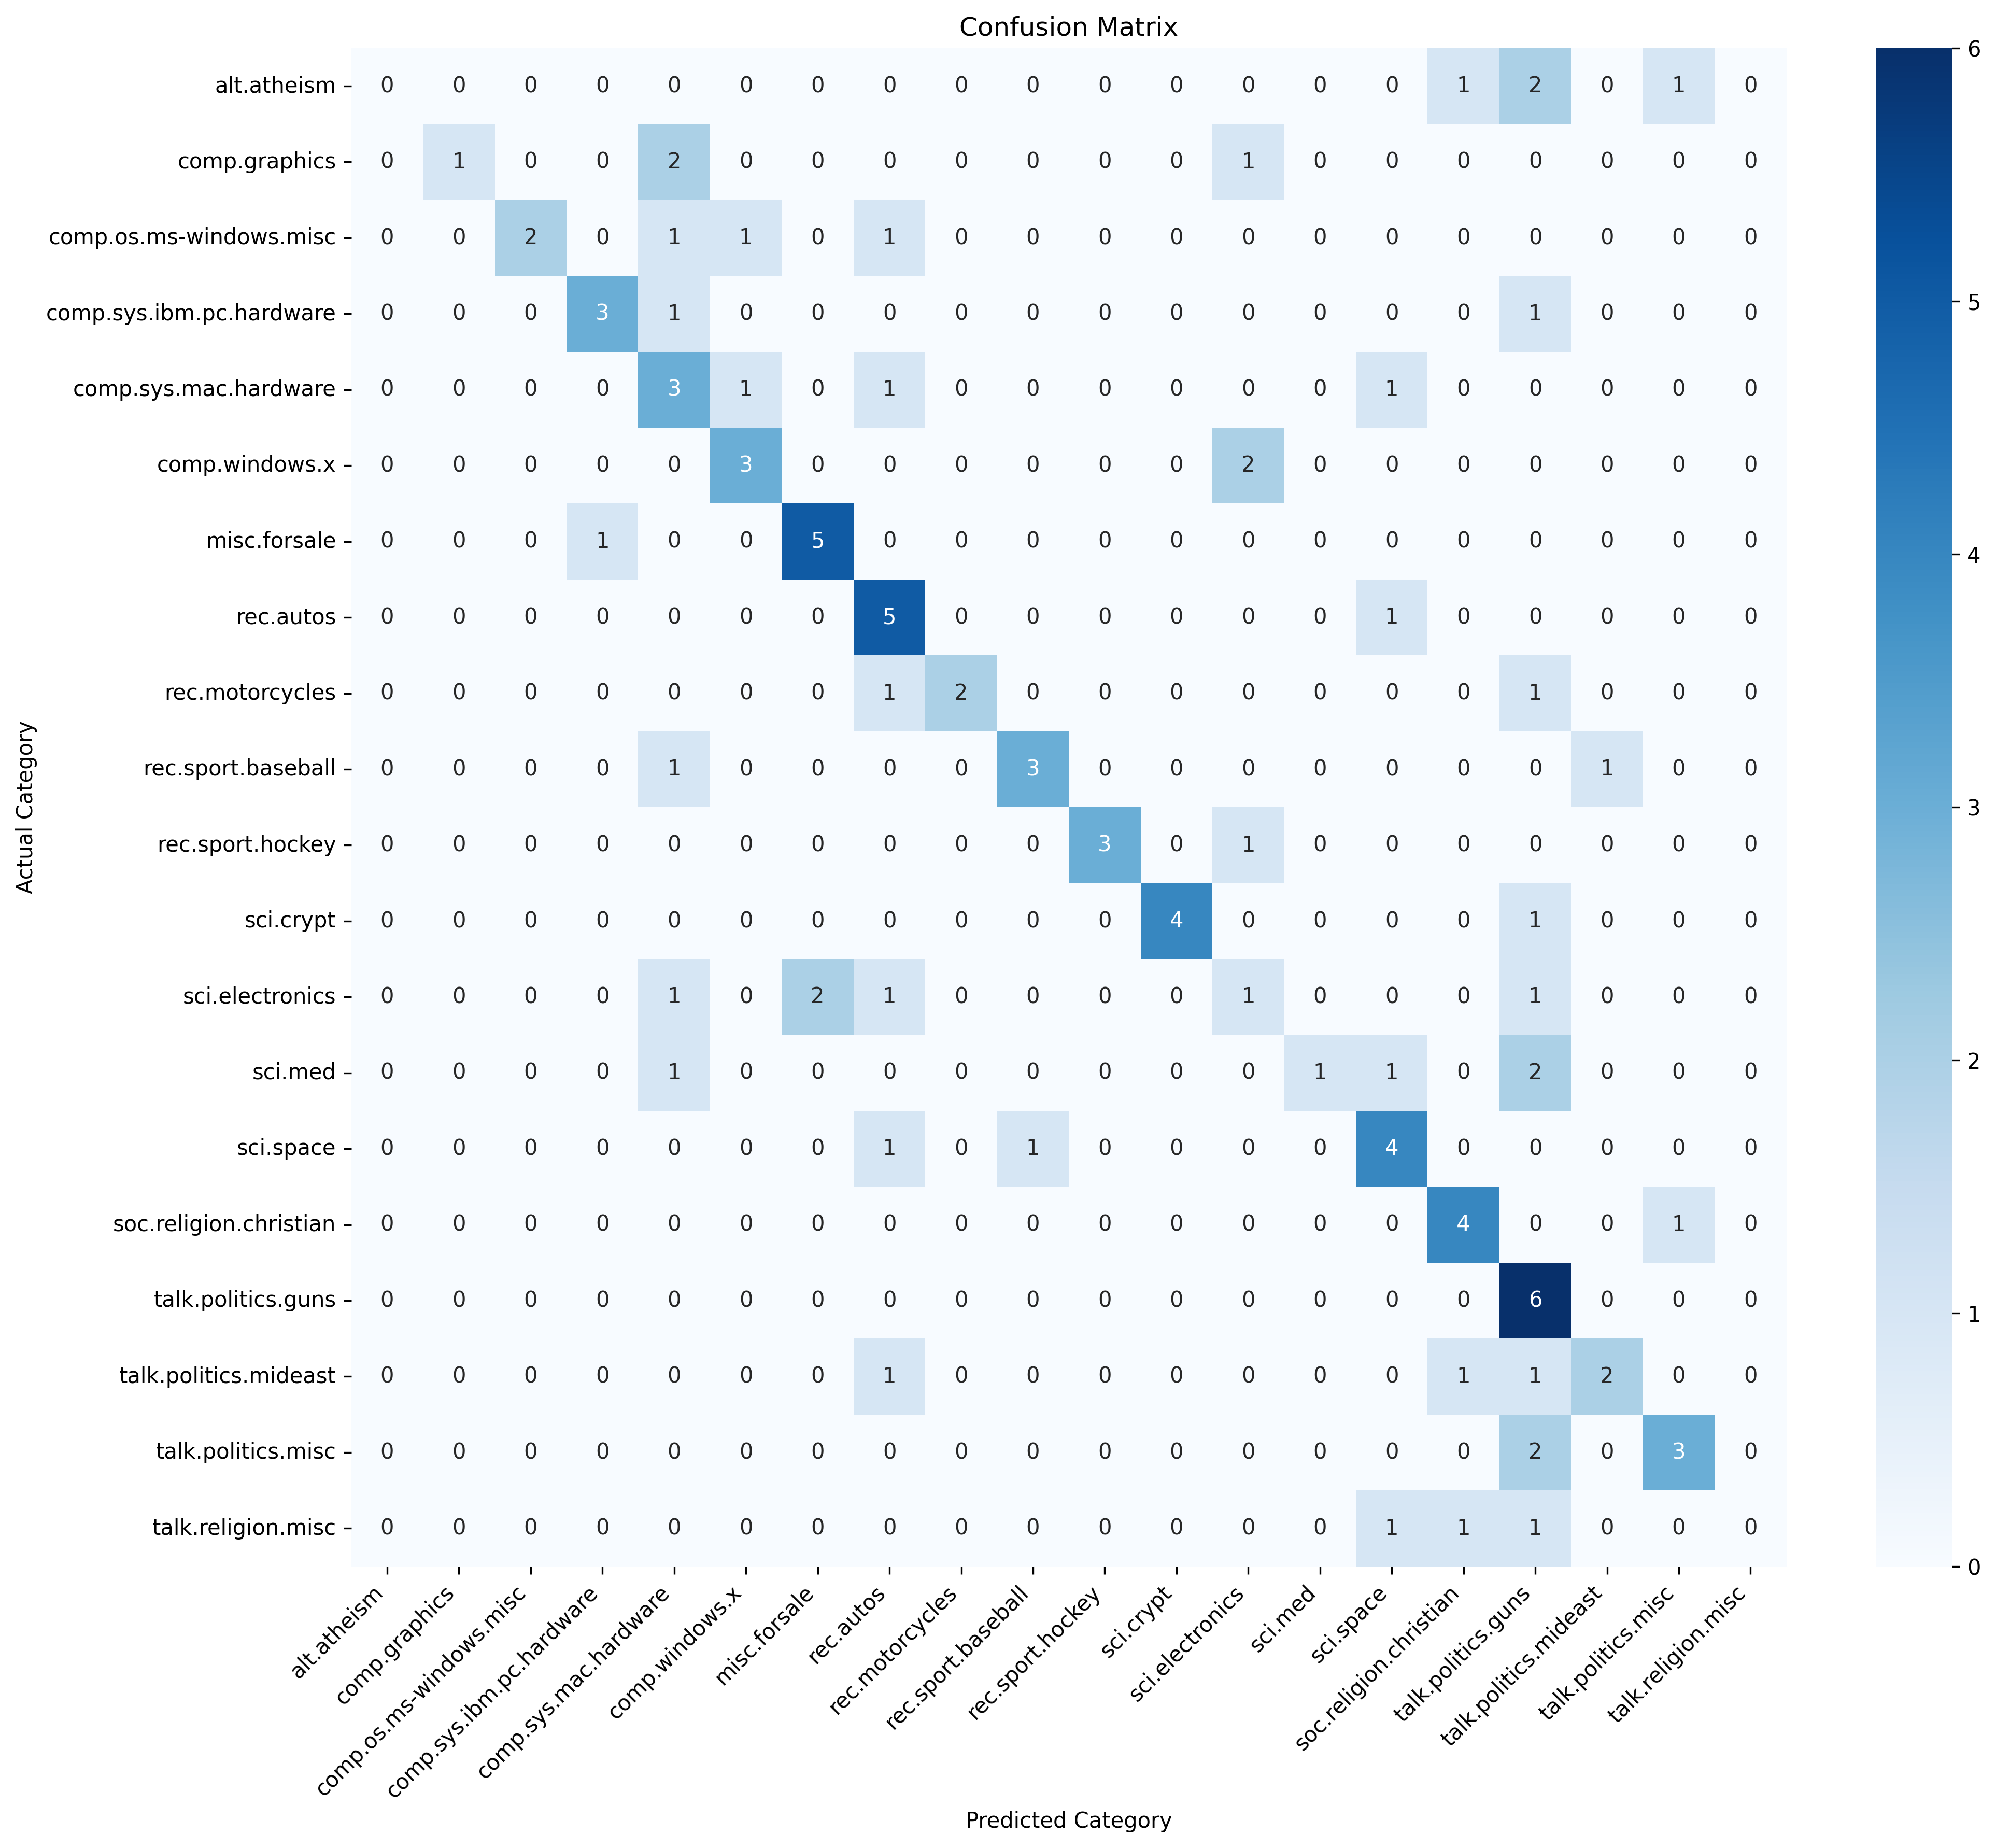


top_errors.png:


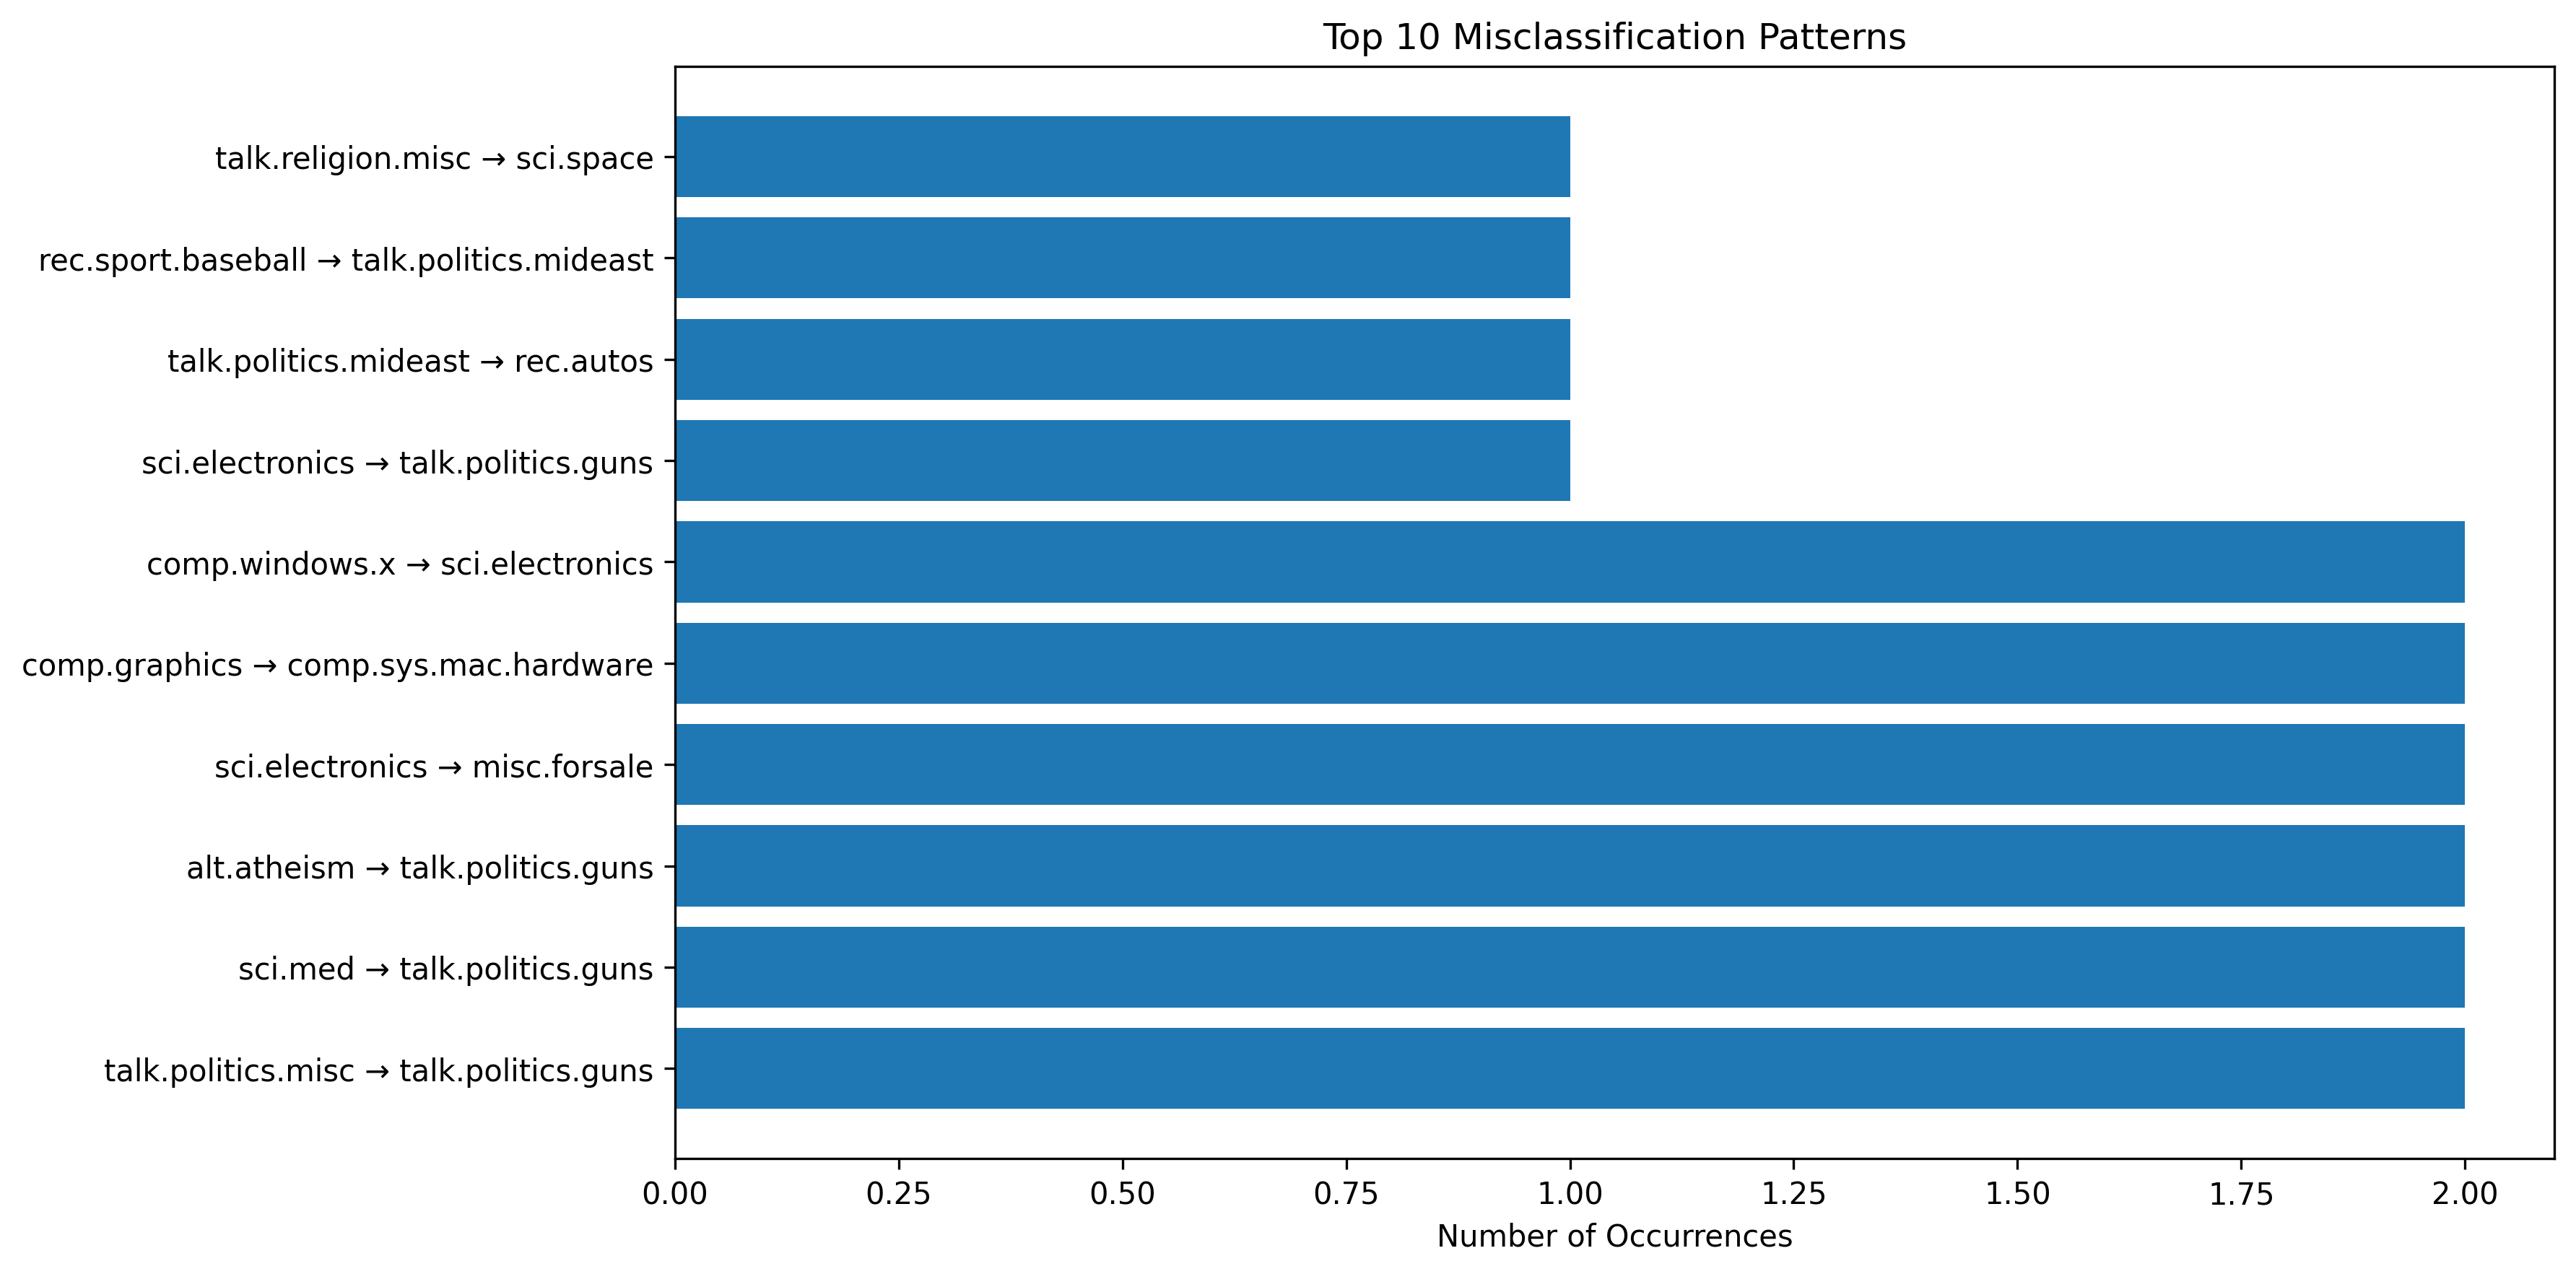

🧹 Sandbox will auto-delete in 10 minutes


In [9]:
# ============================================================================
# STEP 9: Run the Classification
# ============================================================================
await run_classification()